In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import Necessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
random.shuffle(image_data)

In [3]:
path = "C:\\Users\\hoorm\\Desktop\\Codes\\Internship\\PRODIGY_ML_04\\leapGestRecog"
folders = os.listdir(path)
inner_folders = os.listdir(path+"/01")
categories=[]
for i in inner_folders:
  category = i.split('_', maxsplit=1)[1:]
  categories.append(category[0])
num_classes = len(categories)
categories

['palm',
 'l',
 'fist',
 'fist_moved',
 'thumb',
 'index',
 'ok',
 'palm_moved',
 'c',
 'down']

In [4]:
print(os.listdir(r"C:\\Users\\hoorm\\Desktop\\Codes\\Internship\\PRODIGY_ML_04\\leapGestRecog"))

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 'leapGestRecog']


In [5]:
#Load Images
data_dir = "C:\\Users\\hoorm\\Desktop\\Codes\\Internship\\PRODIGY_ML_04\\leapGestRecog\\leapGestRecog"
img_size = (64, 64)  # Resize images to a consistent size
num_classes = 10

images = []
labels = []

# Load images and labels
for main_folder in os.listdir(data_dir):
    main_folder_path = os.path.join(data_dir, main_folder)
    if os.path.isdir(main_folder_path):
        for gesture in os.listdir(main_folder_path):
            gesture_path = os.path.join(main_folder_path, gesture)
            if os.path.isdir(gesture_path):
                for img_file in os.listdir(gesture_path):
                    img_path = os.path.join(gesture_path, img_file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(gesture)
                    else:
                        print(f"Warning: Image at path {img_path} could not be loaded. Check the file format and path.")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with {len(labels)} labels.")

Loaded 20000 images with 20000 labels.


In [6]:
df = pd.DataFrame(columns=['filepaths', 'categories'])
paths, category = [], []

for folder in folders:
    inner_folders = os.listdir(path + '/' + folder)
    for inner_f in inner_folders:
        files = os.listdir(path + '/' + folder + "/" + inner_f)
        for file in files:
            paths.append(folder + '/' + inner_f + '/' + file)
            split_inner_f = inner_f.split('_', maxsplit=1)
            if len(split_inner_f) > 1:
                category.append(split_inner_f[1])
            else:
                category.append('default_category')  # We can replace 'default_category' with a value you prefer

df['filepaths'] = paths
df['categories'] = category


In [7]:
im_size = (224, 224)
im_width, im_height = im_size
im_channels=1
batch_size = 50

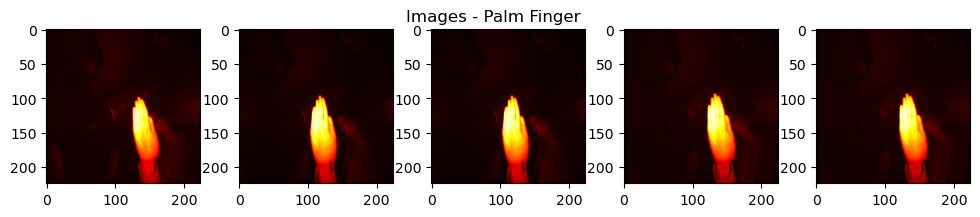

In [8]:
fig = plt.figure(figsize=(12,2))
fig.suptitle("Images - Palm Finger")

for i in range(5):
  img = Image.open(path+'/'+df['filepaths'][i])
  img = img.resize(im_size)
  plt.subplot(1, 5, i+1)
  plt.imshow(img, cmap='hot')
  # print(img.shape)
plt.show()

In [9]:
if len(images) == 0 or len(labels) == 0:
    raise ValueError("No images or labels were loaded. Please check the dataset path and contents.")

In [10]:
#Normalize the images
images = images.astype('float32') / 255.0

In [11]:
#Encode labels to numerical values
label_names = sorted(set(labels))
label_map = {label: idx for idx, label in enumerate(label_names)}
encoded_labels = np.array([label_map[label] for label in labels])

In [12]:
#One-hot encode the labels
encoded_labels = to_categorical(encoded_labels, num_classes)

In [13]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

In [14]:
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (16000, 64, 64, 3), (16000, 10)
Testing data shape: (4000, 64, 64, 3), (4000, 10)


In [15]:
#Display class names and their corresponding labels
print("Class labels and their corresponding indices:")
for label, idx in label_map.items():
    print(f"{idx}: {label}")

Class labels and their corresponding indices:
0: 01_palm
1: 02_l
2: 03_fist
3: 04_fist_moved
4: 05_thumb
5: 06_index
6: 07_ok
7: 08_palm_moved
8: 09_c
9: 10_down


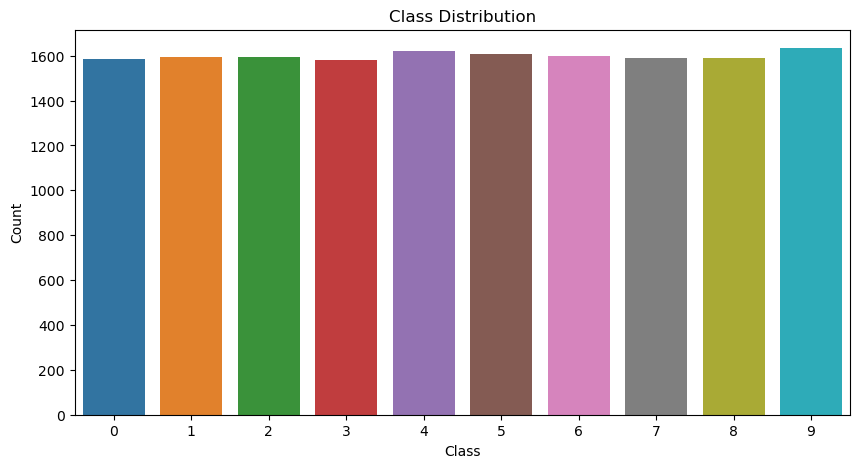

In [16]:
#Visualize the class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=np.argmax(y_train, axis=1))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=123)
train_df[:5]

,filepaths,categories
13498,06/08_palm_moved/frame_06_08_0099.png,palm_moved
2268,01/02_l/frame_01_02_0069.png,l
6481,03/03_fist/frame_03_03_0082.png,fist
1731,00/09_c/frame_00_09_0132.png,c
12809,06/05_thumb/frame_06_05_0010.png,thumb


In [18]:
train_datagen = ImageDataGenerator(rescale=1/.255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 16000 validated image filenames belonging to 10 classes.


In [19]:
val_datagen = ImageDataGenerator(rescale=1/.255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)    

Found 1998 validated image filenames belonging to 10 classes.


In [20]:
# Convert string labels to integers
categories, labels = np.unique(labels, return_inverse=True)
num_classes = len(categories)

print(f"Loaded {len(images)} images with {len(labels)} labels.")

Loaded 20000 images with 20000 labels.


In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [22]:
# Normalize the images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape images to fit model input requirements (if needed)
X_train = X_train.reshape(-1, img_size[0], img_size[1], 3)  # Assuming images are RGB
X_test = X_test.reshape(-1, img_size[0], img_size[1], 3)

In [23]:
def preprocess_images(images, target_size=(224, 224)):
    preprocessed_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_gray = img_gray.reshape(target_size[0], target_size[1], 1)
        preprocessed_images.append(img_gray)
    return np.array(preprocessed_images)

X_train_preprocessed = preprocess_images(X_train, target_size=(224, 224))

# Update the model to expect (224, 224, 1) input shape

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # num_classes is the number of output classes
])


In [24]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the learning rate reducer callback
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, cooldown=1, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[lr_reducer])


Epoch 1/10
400/400 [==============================] - 25s 61ms/step - loss: 1.7804 - accuracy: 0.4316 - val_loss: 1.1614 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - 24s 59ms/step - loss: 0.8752 - accuracy: 0.7551 - val_loss: 0.6678 - val_accuracy: 0.8031 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - 23s 57ms/step - loss: 0.5412 - accuracy: 0.8424 - val_loss: 0.4584 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - 23s 57ms/step - loss: 0.3336 - accuracy: 0.9190 - val_loss: 0.2843 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 5/10
400/400 [==============================] - 23s 57ms/step - loss: 0.2073 - accuracy: 0.9604 - val_loss: 0.1925 - val_accuracy: 0.9716 - lr: 0.0010
Epoch 6/10
400/400 [==============================] - 23s 57ms/step - loss: 0.1335 - accuracy: 0.9753 - val_loss: 0.1338 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 7/10
400/400 [==============================] - 23s 

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_accuracy * 100))

125/125 [==============================] - 1s 10ms/step - loss: 0.0333 - accuracy: 0.9960
Test accuracy: 99.60%


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 128)               3936384   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3938570 (15.02 MB)
Trainable params: 3938570 (15.02 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [27]:
# Generate predictions for confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=categories))


125/125 [==============================] - 1s 10ms/step
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       417
         02_l       1.00      1.00      1.00       404
      03_fist       0.98      0.99      0.99       404
04_fist_moved       1.00      0.99      1.00       418
     05_thumb       1.00      0.99      0.99       377
     06_index       0.99      1.00      1.00       392
        07_ok       1.00      1.00      1.00       403
08_palm_moved       1.00      1.00      1.00       409
         09_c       1.00      1.00      1.00       410
      10_down       1.00      1.00      1.00       366

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



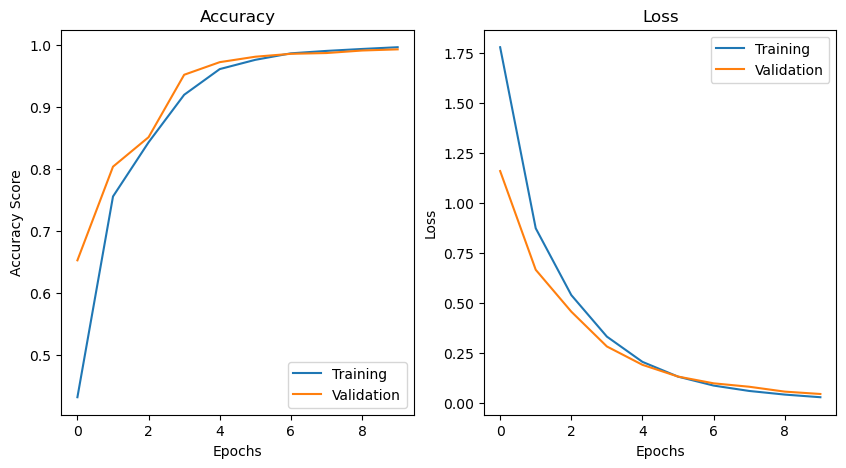

In [28]:
# Plot the training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


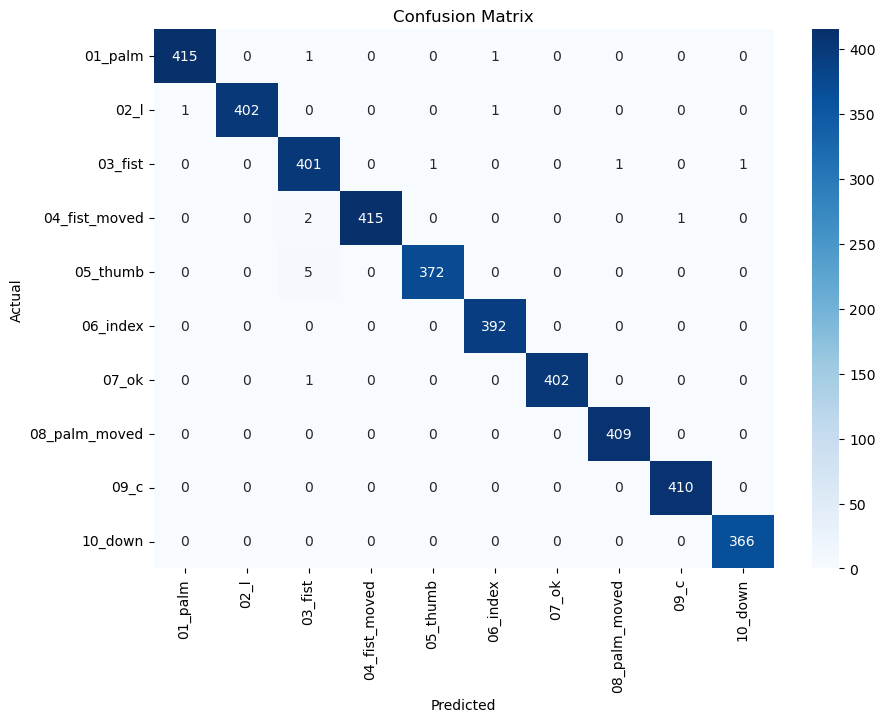

In [29]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Define ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image data
    # other data augmentation parameters if needed
)

# Define the test generator
basic_test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path+'/',  # Ensure this is correct, points to the base directory of images
    x_col='filepaths',
    y_col='categories',
    target_size=im_size,  # (height, width)
    color_mode='grayscale',
    class_mode='categorical',  # for multi-class classification with one-hot encoded labels
    batch_size=batch_size,
    shuffle=False  # Typically set to False for evaluation
)


Found 2002 validated image filenames belonging to 10 classes.


In [31]:
test_df[40:48]

,filepaths,categories
10635,05/04_fist_moved/frame_05_04_0036.png,fist_moved
354,00/02_l/frame_00_02_0155.png,l
3364,01/07_ok/frame_01_07_0165.png,ok
16226,08/02_l/frame_08_02_0027.png,l
14696,07/04_fist_moved/frame_07_04_0097.png,fist_moved
2314,01/02_l/frame_01_02_0115.png,l
4337,02/02_l/frame_02_02_0138.png,l
5163,02/06_index/frame_02_06_0164.png,index


In [32]:
sample_imgs=[]
for img_paths in test_df[100:108]['filepaths']:
  img = Image.open(path+'/'+img_paths)
  img = img.resize(im_size)
  img = img.convert('L')
  img = np.array(img)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  sample_imgs.append(img)
sample_imgs = np.array(sample_imgs)
sample_imgs.shape

(8, 224, 224, 1)

In [33]:
categories = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

data_path = r"C:\\Users\\hoorm\\Desktop\\Codes\\Internship\\PRODIGY_ML_04"

image_data = []
for root, dirs, files in os.walk(data_path):
    for dir in dirs:
        if dir in categories:
            class_index = categories.index(dir)
            dir_path = os.path.join(root, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])

if image_data:
    print(image_data[0])
else:
    print("No images found")

[array([[5, 4, 4, ..., 3, 4, 2],
       [5, 4, 5, ..., 3, 3, 3],
       [4, 5, 4, ..., 4, 5, 3],
       ...,
       [4, 5, 5, ..., 5, 5, 5],
       [5, 5, 6, ..., 5, 7, 4],
       [4, 7, 5, ..., 5, 4, 4]], dtype=uint8), 0]


In [35]:
# shuffle the input data
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

In [36]:
label[:10]

[4, 7, 5, 7, 5, 5, 1, 6, 5, 2]

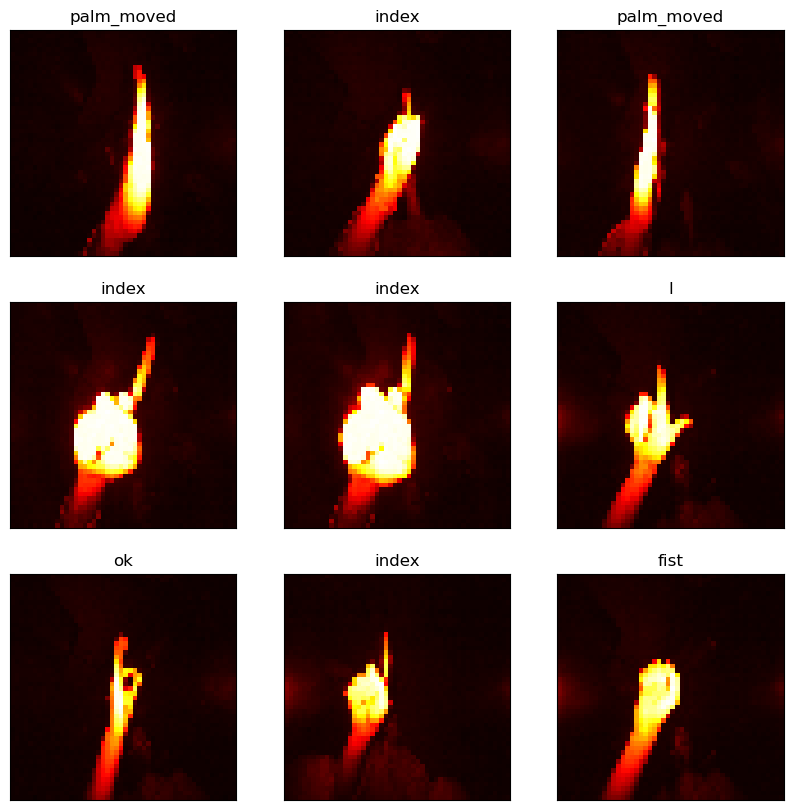

In [37]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(categories[label[i]][3:])
plt.show()

In [38]:
#Save the model
model.save('hand_gesture_recognition_model.h5')